# 2. PyMCについてもう少し深く触れる

## 2.1 はじめに

---
PyMCに使用する変数は2パターンに分けられる

- 親変数(parent variable)
- 子変数 (child variable)

親変数は他の変数に影響を及ぼす変数（引数として与えられたり、計算式に入れられたりする）で、子変数は親変数から影響をうける変数

In [185]:
%matplotlib inline

In [186]:
import pymc as pm

In [187]:
import numpy as np

In [188]:
# この場合lambda_が親変数
lambda_ = pm.Exponential('poisson_param', 1)

# 引数にlambda_が与えられて、lambda_の値によってdata_generatorの値が変化する。
# lambda_は親変数
# data_generatorは子変数
data_generator = pm.Poisson('data_generator', lambda_)

# 　data_plus_oneはdata_generatorに+1された値。data_generatorによってdata_plus_oneの値が変化する
# data_generatorは親変数
# data_plus_oneは子変数
data_plus_one = data_generator + 1

各pymc変数の親変数、子変数はparents属性, children属性でアクセスできる

In [189]:
lambda_.children

{<pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x11c4c88d0>}

In [190]:
data_generator.children

{<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x11af21278>}

In [191]:
data_generator.parents

{'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x11af102b0>}

In [192]:
for c in lambda_.children:
    if c == data_generator:
        print('lambda_.children is data_generator!!!')

lambda_.children is data_generator!!!


pymc変数はvalueでその変数の値を取得できる。

この時取得される値は、各pymc変数の内部状況によって変化する。

In [194]:
print('lambda_: ', lambda_.value)
print('data_generator: ', data_generator.value)
print('data_plus_one: ', data_plus_one.value)

lambda_:  0.2194024380251362
data_generator:  0
data_plus_one:  1


pymc変数は2種類に分類される

### stochastic変数
決定的でない、引数とか数式が与えられても確率的に値が変化する変数。確率分布によって値が変化する変数って覚えておけばおｋ
### deterministic変数
決定的な変数。上の例ではdata_plus_one。なぜならdata_generatorの値が決まればそれに1足すだけで他の値に変化することはないため。

stochastic変数はrandom()メソッドを呼び出せば新しい値が生成される。

In [196]:
print("lambda_: ", lambda_.value)
print("data_generator: ", data_generator.value)
print("data_plus_one: ", data_plus_one.value)

print("\n======random()!!!!!=======\n")
lambda_.random()
data_generator.random()

print("lambda_: ", lambda_.value)
print("data_generator: ", data_generator.value)
print("data_plus_one: ", data_plus_one.value)

lambda_:  0.25120148702954864
data_generator:  0
data_plus_one:  1

======random()!!!!!=======

lambda_:  4.295718052545287
data_generator:  2
data_plus_one:  3


deterministic変数は関数で定義できるが、（ぶっちゃけstochastic変数も変数というか確率分布の関数）、pm.deteministicというデコレータつけなきゃいけない

In [197]:
@pm.deterministic
def data_plus_one_(gen=data_generator):
    return gen + 1

In [199]:
hoge = data_plus_one_
print(hoge.value)

3


#### モデルに観測データを組み込む
stochastic変数に固定値で初期化することを指す。

In [203]:
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson('obs', lambda_, value=data, observed=True)
print(obs.value)

[10 25 15 20 35]


観測データを埋め込んだ場合、random()を呼んでもvalueの値は変わらない

In [205]:
obs.random()
obs.value

array([10, 25, 15, 20, 35])

## 2.2 モデリングのアプローチ

ベイズモデリングは全てのデータがある確率に基づいて生成されてると考える。

自分が神様の立場に立ったとして考えろとのこと。

１章のメッセージ受信数データのモデリングの例
1. メッセージ受信数という計数データなので、ポアソン分布からのサンプルだとする
2. ポアソン分布のパラメータ$\lambda$はわからない。データを見ると前半と後半で変わっていそう。変わった変化点を$\tau$とする
3. $\lambda$はわからないので、正の確率分布で表現する。正の確率分布なので指数分布で表現する
4. 指数分布は$\alpha$のパラメータがあるが、$\alpha$は観測データの平均値の逆数とする。
5. $\tau$は何日か検討つかないので一様分布にしちゃう

In [206]:
import daft

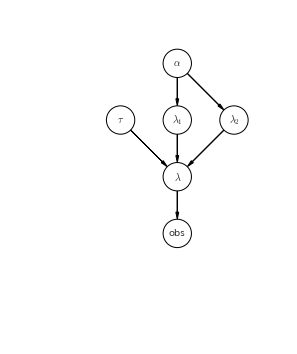

In [207]:
pgm = daft.PGM(shape=[5,6])

pgm.add_node(daft.Node("tau", r"$\tau$", 2, 4))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 3, 5))
pgm.add_node(daft.Node("lambda1", r"$\lambda_1$", 3, 4))
pgm.add_node(daft.Node("lambda2", r"$\lambda_2$", 4, 4))
pgm.add_node(daft.Node("lambda", r"$\lambda$", 3, 3))
pgm.add_node(daft.Node("obs", "obs", 3, 2))


pgm.add_edge("tau", "lambda")
pgm.add_edge("alpha","lambda1")
pgm.add_edge("alpha", "lambda2")
pgm.add_edge("lambda1", "lambda")
pgm.add_edge("lambda2", "lambda")
pgm.add_edge("lambda", "obs")

pgm.render()

グラフィカルモデルで表すとこのように表現される。

ベイズモデルをする上でグラフィカルモデルで表現しておくと、実装が分かりやすかったりする。


### 2.2.2 A/Bテストによる例題

WebアプリのConversionに対して、Aという条件、Bという条件でConversionする確率$P_a$, $P_b$に差異があるかの調査をする。

In [237]:
### 神様コーナー
p_true = 0.05
N = 1500

occurences = pm.rbernoulli(p_true, N)

print(occurences)
print(occurences.sum())
print(occurences.sum() / N)

[False False False ..., False False False]
73
0.0486666666667


頻度統計主義では$P_a$は真の確率と異なる

Conversionする、しないは2値であり、2値の確率変数を扱うのは **ベルヌーイ分布** が適している

$X \sim Ber(p)$

と表現し、Xは確率$p$で1の値を取り、$1-p$で0の値を取るという分布である

パラメータ１つしかないので単純だけど、グラフィカルモデルで表現するとこうなる

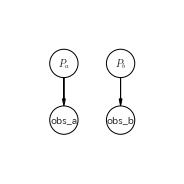

In [238]:
pgm = daft.PGM(shape=[3,3])

pgm.add_node(daft.Node("p_a", r"$P_a$", 1, 2))
pgm.add_node(daft.Node("obs_a", "obs_a", 1, 1))
pgm.add_node(daft.Node("p_b", r"$P_b$", 2, 2))
pgm.add_node(daft.Node("obs_b", "obs_b", 2, 1))

pgm.add_edge("p_a", "obs_a")
pgm.add_edge("p_b", "obs_b")

pgm.render()

現在、$P_a$の確率は不明のため0~1の一様分布で事前分布を設定する

そして観測データをベルヌーイ分布に設定し、$P_a$の事後分布を設定する

In [239]:
p_a = pm.Uniform('p_a', lower=0, upper=1)

obs = pm.Bernoulli('obs', p_a, value=occurences, observed=True)

In [240]:
mcmc = pm.MCMC([p_a, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.3 sec

In [241]:
from matplotlib import pyplot as plt
import seaborn

In [242]:
from IPython.core.pylabtools import figsize

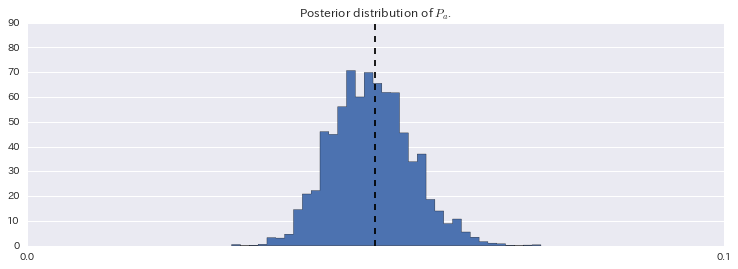

In [243]:
figsize(12.5, 4)

data = mcmc.trace('p_a')[:]

plt.vlines(p_true, 0, 90, linestyle='--', label='true $P_a$ (unkonwn)')
plt.hist(data, bins=35, histtype='stepfilled', normed=True)
plt.xticks([0.0, 0.10])
plt.title('Posterior distribution of $P_a$.')
plt.show()

同じようにBという条件での確率 $P_b$ を出してみる

In [308]:
### 神様コーナー
p_b_true = 0.04
Nb = 750

occurences_B = pm.rbernoulli(p_b_true, Nb)

print(occurences_B.sum())
print(occurences_B.sum() / Nb)

35
0.0466666666667


In [309]:
p_b = pm.Uniform('p_b', 0, 1)

obs_b = pm.Bernoulli('obs_b', p_b, value=occurences_B, observed=True)

@pm.deterministic
def delta(p_a=p_a, p_b=p_b):
    return p_a - p_b

In [310]:
mcmc = pm.MCMC([p_a, obs, p_b, obs_b, delta])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.3 sec

ベイズ推定によるA/Bテストの結果を確認してみる

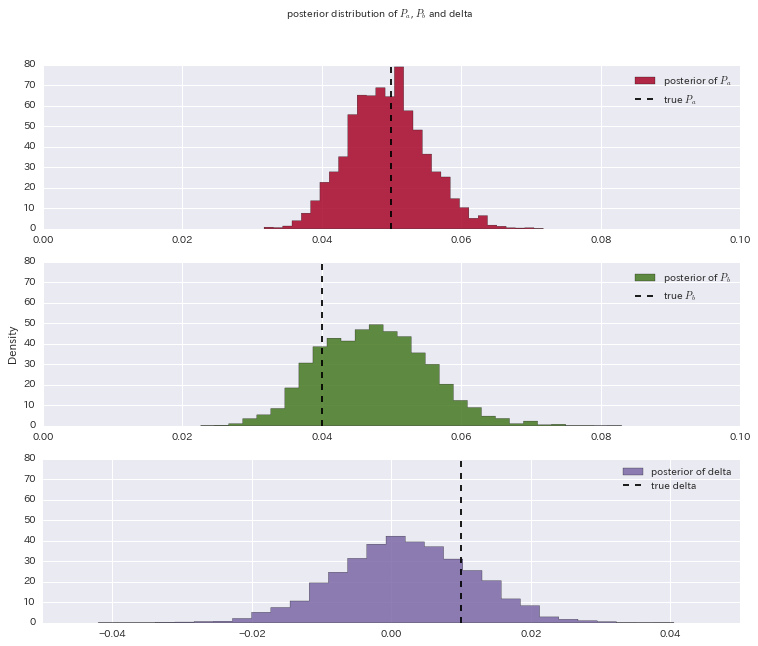

In [311]:
p_a_samples = mcmc.trace('p_a')[:]
p_b_samples = mcmc.trace('p_b')[:]
delta_samples = mcmc.trace('delta')[:]

figsize(12.5, 10)

ax = plt.subplot(311)
plt.hist(p_a_samples, histtype='stepfilled', bins=30, normed=True, alpha=0.85, label='posterior of $P_a$', color='#A60628')
plt.vlines(p_true, 0, 80, linestyle='--', label='true $P_a$')
plt.legend(loc='upper right')
plt.xlim(0, .1)
plt.ylim(0, 80)
plt.suptitle('posterior distribution of $P_a$, $P_b$ and delta')

ax = plt.subplot(312)
plt.hist(p_b_samples, histtype='stepfilled', bins=30, normed=True, alpha=0.85, label='posterior of $P_b$', color='#467821')
plt.vlines(p_b_true, 0, 80, linestyle='--', label='true $P_b$')
plt.legend(loc='upper right')
plt.xlim(0, .1)
plt.ylim(0, 80)
plt.ylabel('Density')

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, normed=True, alpha=0.85, label='posterior of delta', color='#7A68A6')
plt.vlines(p_true-p_b_true, 0, 80, linestyle='--', label='true delta')
plt.legend(loc='upper right')
plt.ylim(0, 80)

plt.show()

この結果だとAの方が良いかなーと言う印象。

Bの方のデータをもっと集めると$P_b$の事後確率がさらに信頼できるものとなり、良い比較ができそうとかって分析ができたりする

### 2.2.3 カンニングをした学生の割合

試験を受験する生徒N人のうち、カンニングをした学生の割合を推定する。
カンニングをする確率を$p$とする。

試験後学生にアンケートを取り、「カンニングをしました」という回答を得るイベントの回数をXとする。

モデリングをする内容は$p$の事前分布から観測データXにもとづき、$p$の事後分布を得ることである。

#### 嘘をモデリングする

学生が嘘付く可能性も考慮して、嘘もモデリングに入れる。
1. 学生にアンケートを取る際に、見えないところでコインを投げてもらう
2. 表が出たら正直に回答してもらう
3. 裏が出たらもう1度コインを投げる
4. 2回目のコインで表が出たら「カンニングをしました」、裏が出たら「カンニングをしてません」と回答してもらう

In [254]:
hoge = pm.Uniform('uni', 0, 1)
s = []
for i in range(1000):
    s.append(hoge.value)
    hoge.random()

In [256]:
import pandas as pd

In [258]:
fuga = pd.DataFrame(s)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1186ea208>]], dtype=object)

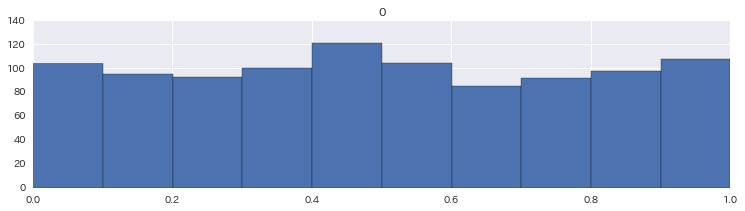

In [260]:
fuga.hist()

In [248]:
N = 100 # 学生が100人
p = pm.Uniform('freq_cheating', 0, 1) # 学生がカンニングする割合は不明のため、 事前確率は0~1の一様分布とする

true_answers = pm.Bernoulli('truths', p, size=N) # 実際にカンニングしたかどうかはベルヌーイ分布で表現する

first_coin_flips = pm.Bernoulli('first_flips', 0.5, size=N) # 最初のコインの結果。コインの結果はp=1/2のベルヌーイ分布で生成されるとする。
second_coin_flips = pm.Bernoulli('second_flips', 0.5, size=N)

# 実際に観測されるのはコインの結果によって変化する。
# 1回目が表だったら実際にカンニングしたかどうか
# １回目が裏だったら、２回目のコインの結果
# この変数はカンニングをしたと回答した割合を表す
@pm.deterministic
def observed_propotion(t_a=true_answers, fc=first_coin_flips, sc=second_coin_flips):
    observed = fc * t_a + (1 - fc) * sc
    return observed.sum() / float(N)

もし学生が誰もカンニングをしなかったとする。

すると「カンニングをした」と回答する数は、１回目に裏が出て、２回目に表がある場合なので、 0.5 * 0.5 = 0.25の確率で起き、１００人いるので約２５人ぐらいから「カンニングをした」と回答が得られるはずである。

もし、回答結果が３５人からカンニングをしたと得られたとすると、観測データは以下のように定義できる

In [251]:
X = 35
observations = pm.Binomial('obs', N, observed_propotion, value=X, observed=True)

ここで出てきたBenomialとは **二項分布**である。

二項分布はパラメータを２つ持つ。試行回数Nと、イベントが発生する確率が$p$である。Xが二項分布に従うとはN回施行したら、イベントがX回となる分布を表す。

モデリングができたので、MCMCを使って事後確率を推定する

In [252]:
mcmc = pm.MCMC([p, true_answers, first_coin_flips, second_coin_flips, observed_propotion, observations])
mcmc.sample(40000, 15000)

 [-----------------100%-----------------] 40000 of 40000 complete in 13.6 sec

最初に確認したかった「学生がカンニングをする確率」の事後確率を確認してみる

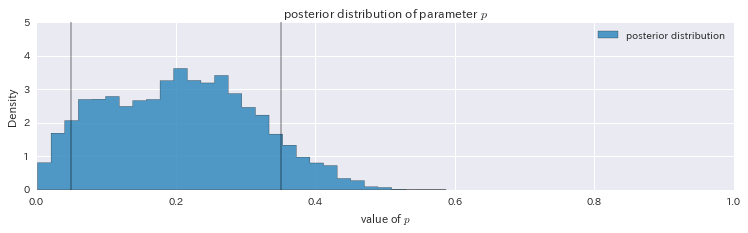

In [253]:
figsize(12.5, 3)

p_trace = mcmc.trace('freq_cheating')[:]
plt.hist(p_trace, histtype='stepfilled', normed=True, alpha=0.85, bins=30, color='#348ABD', label='posterior distribution')
plt.vlines([.05, .35], [0, 0], [5,5], alpha=0.3)
plt.xlim(0, 1)
plt.xlabel('value of $p$')
plt.ylabel('Density')
plt.title('posterior distribution of parameter $p$')
plt.legend()

plt.show()

この結果からわかることは、
- カンニングをする確率は20%ぐらいっぽい気がするけど、そこまで確信が持ててない（振れ幅が大きい）
- $p$が0である確率（カンニングが全く起きなかった確率）はほぼ小さいので、カンニングが起きたことはほぼ確信できる

### 2.2.4 スペースシャトルが故障する確率

昔のアメリカで起きたスペースシャトル事故の事例。

ロケットブースター溶接部の部品であるOリングの破損が原因らしいが、過去の実験データからはスペースシャトル事故とOリングの破損は関係ないとみなされてたっぽい。

In [35]:
import pandas as pd

In [39]:
challenger_data_df = pd.read_csv('https://git.io/vXknD')

In [261]:
challenger_data_df

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,6/27/82,80,NaN
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


In [41]:
challenger_data_df.dropna()

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1
10,04/06/1984,63,1


In [262]:
challenger_data = challenger_data_df[['Temperature', 'Damage Incident']].dropna()[:-1].as_matrix().astype('float64')

In [263]:
challenger_data

array([[ 66.,   0.],
       [ 70.,   1.],
       [ 69.,   0.],
       [ 68.,   0.],
       [ 67.,   0.],
       [ 72.,   0.],
       [ 73.,   0.],
       [ 70.,   0.],
       [ 57.,   1.],
       [ 63.,   1.],
       [ 70.,   1.],
       [ 78.,   0.],
       [ 67.,   0.],
       [ 53.,   1.],
       [ 67.,   0.],
       [ 75.,   0.],
       [ 70.,   0.],
       [ 81.,   0.],
       [ 76.,   0.],
       [ 79.,   0.],
       [ 75.,   1.],
       [ 76.,   0.],
       [ 58.,   1.]])

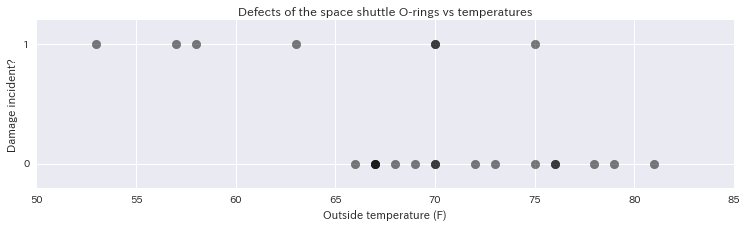

In [264]:
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color='k', alpha=0.5)
plt.yticks([0, 1])
plt.ylabel('Damage incident?')
plt.xlabel('Outside temperature (F)')
plt.title('Defects of the space shuttle O-rings vs temperatures')

気温が下がると故障確率が上がってるようにみえる。

特に明確なしきい値はわかりにくいため（65F以下だと起きるみたいな）、ある気温$t$だと故障する確率はx%みたいな確率$p(t)$を考えなければならない

この確率$p(t)$は気温が下がると1に近づき、気温が上がると徐々に0に近づいていくような関数で表現する必要がある。

そのような表現をする関数はたくさんあるけど、いちばん有名なのは **ロジスティック関数**である。

\begin{align}
&
& p(t) = \frac{1}{1 + e^{\beta t}}
& 
\end{align}

ロジスティック関数は $\beta$をパラメータとしてもち、$\beta$の値によって以下のように形が変わる

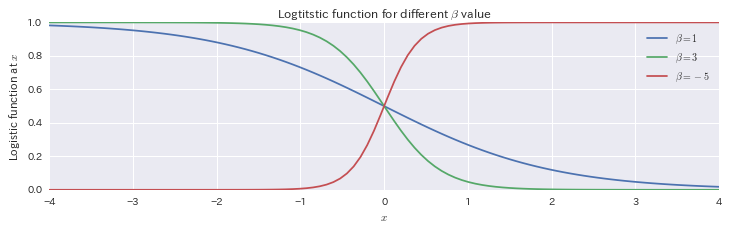

In [265]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta*x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")

plt.xlabel("$x$")
plt.ylabel("Logistic function at $x$")
plt.title(r"Logtitstic function for different $\beta$ value")
plt.legend()

このままだと$x=0$のとき, 0.5の値をとるのはどの$\beta$のときでも変わらないので ($\frac{1}{1 + e^{\beta 0}} = \frac{1}{1 + 1} = 0.5$)

バイアス項$\alpha$を設定しておく


\begin{align}
&
& p(t) = \frac{1}{1 + e^{\beta t+\alpha}}
& 
\end{align}

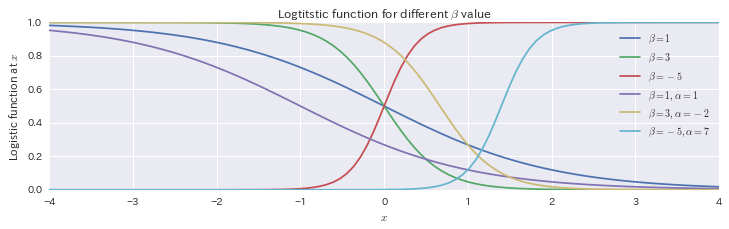

In [266]:
figsize(12, 3)

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(beta*x + alpha))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.plot(x, logistic(x, 1, 1), label=r"$\beta=1, \alpha=1$")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha=-2$")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha=7$")

plt.xlabel("$x$")
plt.ylabel("Logistic function at $x$")
plt.title(r"Logtitstic function for different $\beta$ value")
plt.legend()

$\alpha$の値をいれるとグラフが左右に平行移動する

PyMCを使ってモデリングしていく！

1. 気温$t$において故障する確率をロジスティック関数で表現される$p(t)$で表す
2. $p(t)$は$\alpha$, $\beta$のパラメータを持つ
3. $\alpha$, $\beta$はどんな値でも取りうるけど、どんな値がいいかわからないので、正規分布でモデリングする
4. 正規分布は平均$\mu$と精度$\tau$をパラメータとしてもつ。(pyMCでは分散$\sigma ^2$の逆数である$\tau$を使う。$\sigma ^2 = \frac{1}{\tau}$)
5. 観測データは各気温$t$において、$p(t)$をパラメータとして持つベルヌーイ分布によって生成されるとする

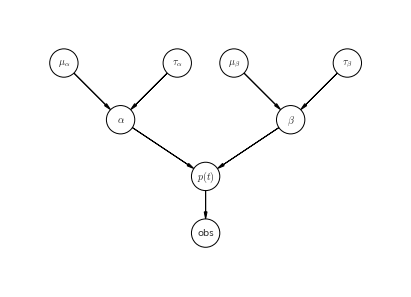

In [267]:
pgm = daft.PGM(shape=[7,5])

pgm.add_node(daft.Node("mu_alpha", r"$\mu_\alpha$", 1, 4))
pgm.add_node(daft.Node("tau_alpha", r"$\tau_\alpha$", 3, 4))
pgm.add_node(daft.Node("mu_beta", r"$\mu_\beta$", 4, 4))
pgm.add_node(daft.Node("tau_beta", r"$\tau_\beta$", 6, 4))

pgm.add_node(daft.Node("alpha", r"$\alpha$", 2, 3))
pgm.add_node(daft.Node("beta", r"$\beta$", 5, 3))

pgm.add_node(daft.Node("p_t", r"$p(t)$",3.5, 2))

pgm.add_node(daft.Node("obs", "obs", 3.5, 1))

pgm.add_edge("mu_alpha", "alpha")
pgm.add_edge("tau_alpha", "alpha")
pgm.add_edge("mu_beta", "beta")
pgm.add_edge("tau_beta", "beta")
pgm.add_edge("alpha", "p_t")
pgm.add_edge("beta", "p_t")
pgm.add_edge("p_t", "obs")

pgm.render()

#### 正規分布について
---
正規分布で表現される確率変数は以下の式で表現され、平均$\mu$の値を取りやすく、精度$\tau$が大きいと振れ幅が小さくなる特徴を持つ

\begin{align}
&
& f(x|\mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp{\biggl(-\frac{\tau}{2}(x - \mu)^2 \biggr)} 
& 
\end{align}

確率変数$A$が正規分布で表現される時

\begin{align}
&
& A \sim N(\mu, \tau)
& 
\end{align}
と表す

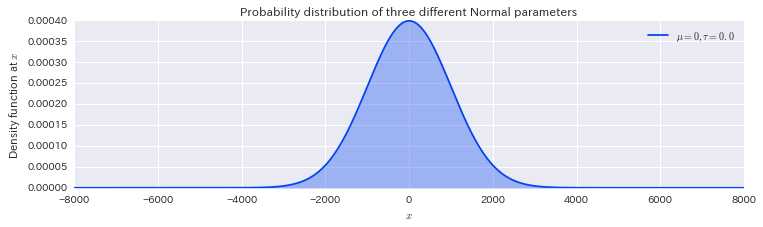

In [273]:
import scipy.stats as stats
nor = stats.norm
colors = ["#348ABD", "#A60628", "#7A68A6", "#0242F3"]

x = np.linspace(-8000, 8000, 15000)
mu = (-2, 0, 3, 0)
tau = (0.7, 1, 2.8, 0.001)
parameters = zip(mu, tau, colors)

for m, t, c in parameters:
    if c == '#0242F3':
        plt.plot(x, nor.pdf(x, m, scale=1. / t), label=r"$\mu = %d, \tau=%.1f$"%(m, t), color=c)
        plt.fill_between(x, nor.pdf(x, m, scale=1. / t), color=c, alpha=0.33)
    
plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("Density function at $x$")
plt.title("Probability distribution of three different Normal parameters")

$\mu$, $\tau$をそれぞれ0, 0.001となるとどの値でも平均的に取りやすくなるので、今回はこの値を採用する

---
話を戻してPyMCでモデリングをしていく

In [274]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]

beta  = pm.Normal("beta",  0, 0.001, value=0)
alpha = pm.Normal("alpha", 0, 0.001, value=0)

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

obs = pm.Bernoulli("obs", p, value=D, observed=True)

In [275]:
model = pm.Model([beta, alpha, obs])
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 11.5 sec

これで$\alpha$, $\beta$の事後分布が得られた

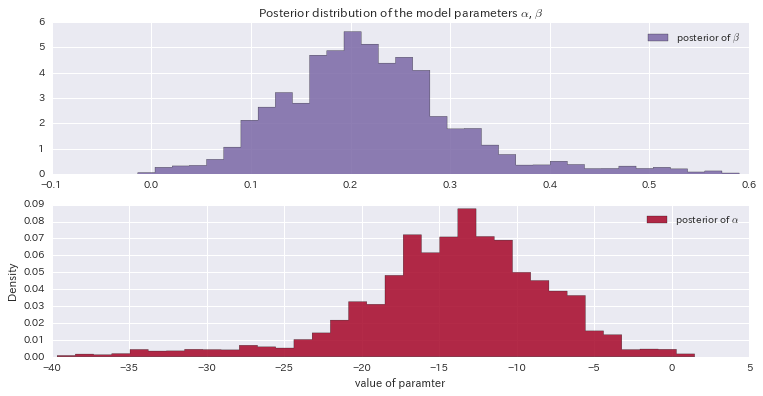

In [276]:
figsize(12.5,  6)

alpha_samples = mcmc.trace('alpha')[:, None]
beta_samples = mcmc.trace('beta')[:, None]

plt.subplot(211)
plt.title('Posterior distribution of 'r"the model parameters $\alpha$, $\beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85, color="#7A68A6", normed=True, label=r"posterior of $\beta$")
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85, color="#A60628", normed=True, label=r"posterior of $\alpha$")

plt.ylabel("Density")
plt.xlabel("value of paramter")
plt.legend()


この結果からわかることは、

- $\beta$が0以外のところに集中してそうなので、外気は破損発生の確率に影響してそう
- $\alpha$の値が負の値なので、気温が下がるほど確率が上がりそう
- データ数は少ないので確信度は低い結果となっている

#### 事後確率から取りうる値をサンプリング
得られた事後分布の$\beta$, $\alpha$から、$p(t)$を計算し、$p(t)$の平均値を出してみる

In [279]:
beta_samples.shape

(10000, 1)

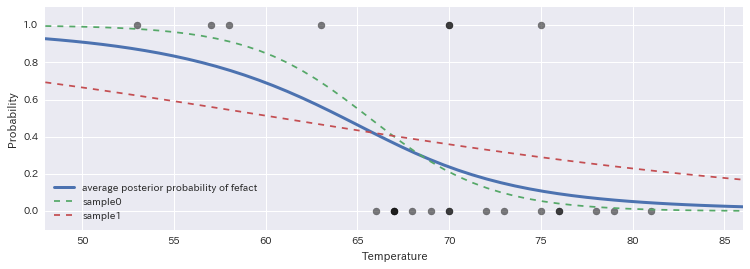

In [277]:
figsize(12.5, 4)

t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_p_t = p_t.mean(axis=0)

plt.plot(t, mean_p_t, lw=3, label='average posterior probability of fefact')
plt.plot(t, p_t[0, :], ls='--', label='sample0')
plt.plot(t, p_t[-1000, :], ls='--', label='sample1')
plt.scatter(temperature, D, color='k', s=50, alpha=0.5)
plt.legend(loc='lower left')
plt.xlim(t.min(), t.max())
plt.ylim(-0.1, 1.1)
plt.ylabel('Probability')
plt.xlabel('Temperature')

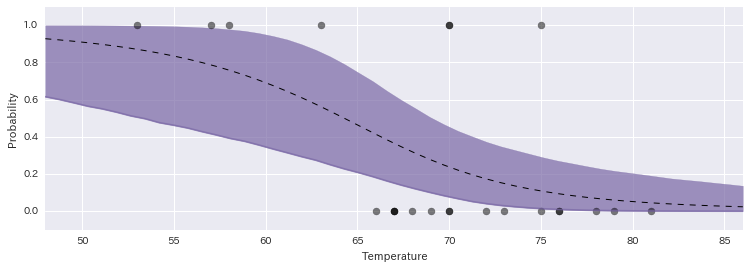

In [280]:
figsize(12.5, 4)

from scipy.stats.mstats import mquantiles
qs = mquantiles(p_t, [0.025, 0.975], axis=0)

plt.fill_between(t[:, 0], *qs, alpha=0.7, color='#7A68A6')
plt.plot(t[:, 0], qs[0], alpha=0.7, color='#7A68A6')
plt.plot(t, mean_p_t, lw=1, ls='--', color='k')

plt.scatter(temperature, D, color='k', s=50, alpha=0.5)
plt.xlim(t.min(), t.max())
plt.ylim(-0.1, 1.1)
plt.ylabel('Probability')
plt.xlabel('Temperature')

太い所は信頼区間が広いので、データ取りまくって信頼度をあげるのが良いと分析できる

## 2.3 このモデルは適切か？

上のスペースシャトルの例では勝手に、気温と故障の確率はロジスティック関数で表現できると決めちゃってるが、それは正しいのか？

筆者曰く、それを判断するのはP値など定量的なもの判断するのはややこしいので、得られたモデルからデータサンプリングしてみて、得られるサンプルデータがどれだけ観測データに似てるか見るのが簡単とのこと

In [291]:
simulation_data = pm.Bernoulli('simulation_data', p)

In [292]:
simulation_data.value

array([ True, False, False, False, False, False, False,  True,  True,
       False, False, False,  True,  True, False, False,  True, False,
       False, False, False, False, False], dtype=bool)

In [304]:
mcmc = pm.MCMC([alpha, beta, obs, simulation_data])
mcmc.sample(10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 2.5 sec

In [305]:
simulationed_data = mcmc.trace('simulation_data')[:]

In [306]:
simulationed_data.shape

(10000, 23)

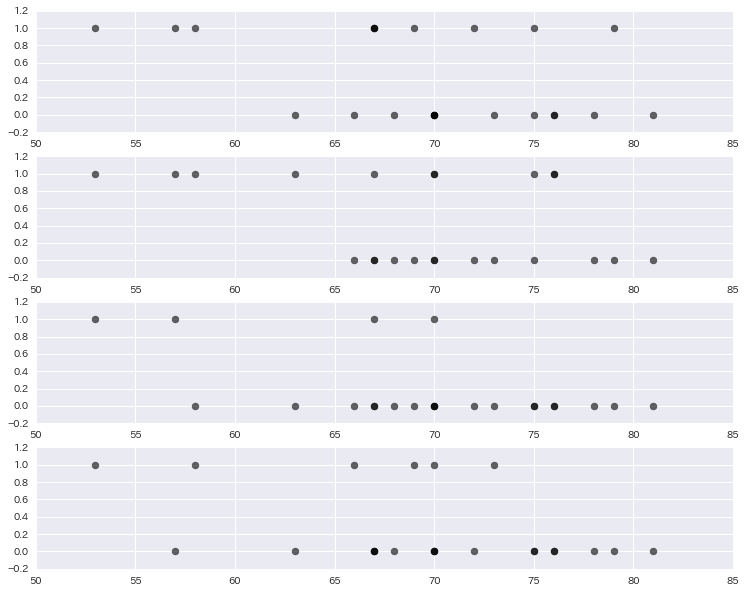

In [307]:
figsize(12.5, 10)
for i in range(4):
    ax = plt.subplot(4, 1, i + 1)
    plt.scatter(temperature, simulationed_data[500 + i, :], color='k', s=50, alpha=0.6)

まぁ観測データに似てるからいっか！みたいなノリらしい

## 2.4 おわりに

この章では
- 実際にPyMCを使ったベイズモデリングの構築方法を見てきた
- 観測データがどのような確率分布に従って生成されたか考えることがベイズモデリングの最初の1歩
- あとはPyMCで数式を作って、MCMCに投げれば事後確率が出てくる
- MCMCの中身は3章で！

### 今日出てきた確率分布
--- 

- ポアソン分布
  - 正の計数分布を表現する
- 指数分布
  - 正の整数の分布を表現する
- 一様分布
  - 特定の範囲で同じ確率で起きる分布を表現する
- ベルヌーイ分布
    - 結果が2値である時、確率pで1をとる分布を表現する
- 二項分布
  - 結果が2値である施行をN回やった時、1が出る数の分布を表現する
- 正規分布
  - 平均$\mu$、精度$\tau$近辺で発生しやすい値の分布を表現する